In [6]:
from pathlib import Path
from E2_report_from_combined import *
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from dataclasses import dataclass
import matplotlib
import matplotlib.colors as mcolors
import functools

from typing import Optional, Callable, Tuple, Dict
import enum

In [7]:
BASE_DIRECTORY = "/Users/phantom/Dev/paperv2/E2"
INPUT_FILE_DIRECTORY = str(Path(BASE_DIRECTORY, "combined"))
files = {
    "neural_network": "neural_network_7layers_result.csv.gz",
    "random_forest": "random_forest_combined_results.csv.gz",
}
FIGSIZE = (24, 9)

@dataclass
class CurveFunctions:
    curve_fn: Callable
    area_fn: Callable
    xaxis: str
    yaxis: str
    title: str

class Metric(enum.Enum):
    AUC = 1
    PRC = 2
    
plot_colors = [str(k) for k in mcolors.TABLEAU_COLORS.keys()]
plot_colors = plot_colors + ["teal", "darkgreen", "navy"]

def prc_curve(x, y):
    precision, recall, thresholds = precision_recall_curve(x, y)
    return recall, precision, thresholds

curve_functions = {
    Metric.AUC: (   
        CurveFunctions(
            curve_fn=roc_curve,
            area_fn=roc_auc_score,
            xaxis="FPR",
            yaxis="TPR",
            title="ROC curve")),
    Metric.PRC: (
        CurveFunctions(
            curve_fn=prc_curve,
            area_fn=auc_pr,
            xaxis="Recall",
            yaxis="Precision",
            title="Precision recall curve"))
}

feature_rename_map = {
    'baseline-only': 'Baseline',
    'advanced-only': 'Advanced',
    'fourier-only': 'Fourier',
    'fourier-min-only': 'Fourier (minimal)',
    'baseline-and-fourier': 'Baseline and advanced',
    'baseline-and-fourier-min': 'Baseline and Fourier (minimal)',
    'baseline-and-advanced': 'Baseline and advanced',
    'advanced-and-fourier': 'Advanced and Fourier',
    'advanced-and-fourier-min': 'Advanced and Fourier (minimal)',
    'baseline-advanced-and-fourier': 'Baseline, advanced and Fourier',
    'baseline-advanced-and-fourier-min': 'Baseline, advanced and Fourier (minimal)'
}

In [8]:
def load_dataframe(
            filename: str,
            plot_office: bool,
            plot_password_protected: bool,
            plot_all: bool) -> pd.DataFrame:
    if (
        filename.lower().endswith(".csv")
        or filename.lower().endswith(".csv.gz")
    ):
        df = pd.read_csv(filename)
    elif (
        filename.lower().endswith(".parquet.gz")
        or filename.lower().endswith(".pq.gz")
        or filename.lower().endswith(".parquet")
        or filename.lower().endswith(".pq")
    ):
        df = pd.read_csv(filename)
    else:
        raise Exception(f"Invalid file type for {filename=}")
    
    df["filename"] = df["filename"].map(remove_base32_from_filename)
    df = df[df["filename"].map(is_file_interesting)]

    if plot_password_protected:
        df = df[df["filename"].map(is_password_protected_file)]
    if plot_office:
        df = df[df["filename"].map(is_office_file)]

    df = df[["feature_set", "y_true", "y_pred", "y_pred_proba"]]

    return df
    

def load_dataframe_wrap(
            modelname: str,
            plot_office: bool,
            plot_password_protected: bool,
            plot_all: bool) -> pd.DataFrame:
    pathname = str(Path(INPUT_FILE_DIRECTORY, files[modelname]))
    return load_dataframe(filename=pathname, plot_office=plot_office, plot_password_protected=plot_password_protected, plot_all=plot_all)


g_colors = None
def get_colors(df: pd.DataFrame) -> Dict[str, str]:
    global g_colors
    if not g_colors:
        feature_names = df["feature_set"].unique().tolist()
        colors = [plot_colors[i] for i in range(len(feature_names))]
        g_colors = {x: y for x, y in zip(feature_names, colors)}
    return g_colors


def plot_roc_curve(
            modelname: str,
            metric: Metric,
            ax: matplotlib.axes._axes.Axes,
            df: Optional[pd.DataFrame] = None,
            add_label: bool = False,
            plot_office: bool = False,
            plot_password_protected: bool = False,
            plot_all:bool = False):
    assert(sum((plot_office, plot_password_protected, plot_all)) == 1)

    if df is None:
        df = load_dataframe_wrap(modelname=modelname, plot_password_protected=plot_password_protected, plot_office=plot_office)
    
    functions = curve_functions[metric]

    roc_data = {}
    for feature_set in df["feature_set"].unique():
        subset = df[df['feature_set'] == feature_set]
        fpr, tpr, _ = functions.curve_fn(subset['y_true'], subset['y_pred_proba'])
        auc_score = functions.area_fn(subset['y_true'], subset['y_pred_proba'])
        roc_data[feature_set] = {'fpr': fpr, 'tpr': tpr, 'auc': auc_score}
    
    colors = get_colors(df)
    plt.figure(figsize=(8, 6))
    for feature_set, data in roc_data.items():
        if add_label:
            ax.plot(data['fpr'], data['tpr'], color=colors[feature_set], label=feature_rename_map[feature_set], linewidth=3.5)
        else:
            line = ax.plot(data['fpr'], data['tpr'], color=colors[feature_set], linewidth=3.5)
    if metric == Metric.AUC:
        ax.plot([0, 1], [0, 1], "--", color="gray", linewidth=3.5)  # Diagonal line representing random classifier
    else:
        noskill = sum(df["y_true"]) / len(df["y_true"])
        ax.axhline(noskill, color='gray', ls='--', linewidth=3.5)
        
    ax.set_xlabel(functions.xaxis)
    ax.set_ylabel(functions.yaxis)
    ax.set_title(functions.title)


def plot_model(
            modelname: str,
            figsize: Tuple[int],
            plot_office: bool = False,
            plot_password_protected: bool = False,
            plot_all:bool = False):
    plt.rcParams.update({'font.size': 30, 'axes.linewidth': 2.5})
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    df = load_dataframe_wrap(modelname, plot_all=plot_all, plot_password_protected=plot_password_protected, plot_office=plot_office)
    plot_roc_curve(modelname=modelname, metric=Metric.AUC, ax=ax[0], df=df, add_label=True, plot_all=plot_all, plot_password_protected=plot_password_protected, plot_office=plot_office)
    plot_roc_curve(modelname=modelname, metric=Metric.PRC, ax=ax[1], df=df, plot_all=plot_all, plot_password_protected=plot_password_protected, plot_office=plot_office)


    fig.legend(loc='upper left', ncol=3, bbox_to_anchor=(0.015, 0))
    fig.tight_layout()
    _ = plt.show()


# Random Forest

All Files


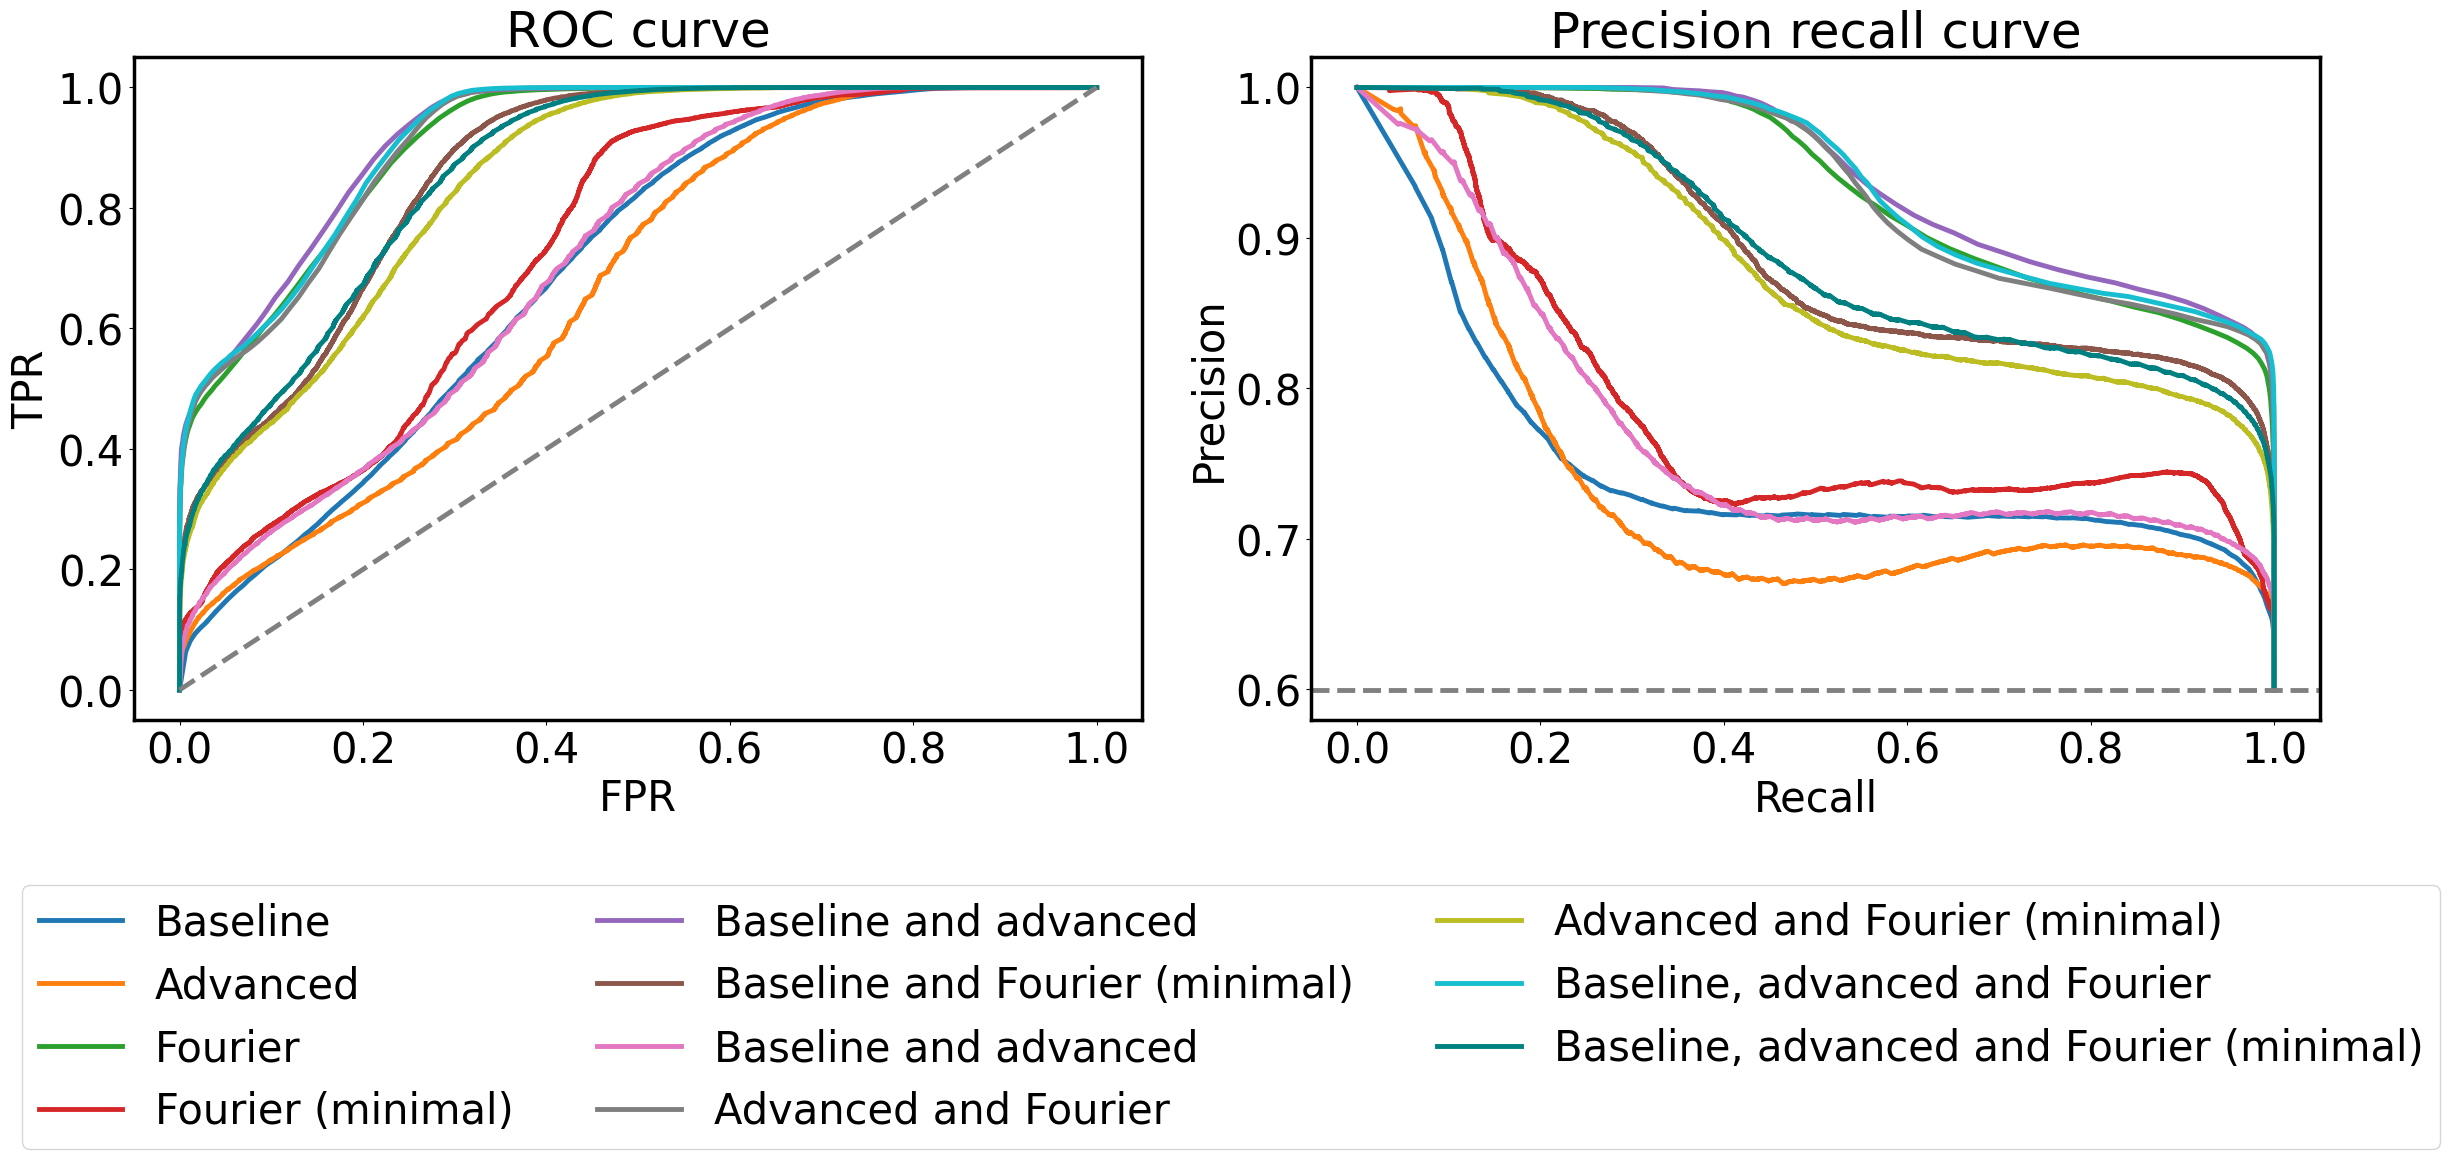

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Password Protected Files


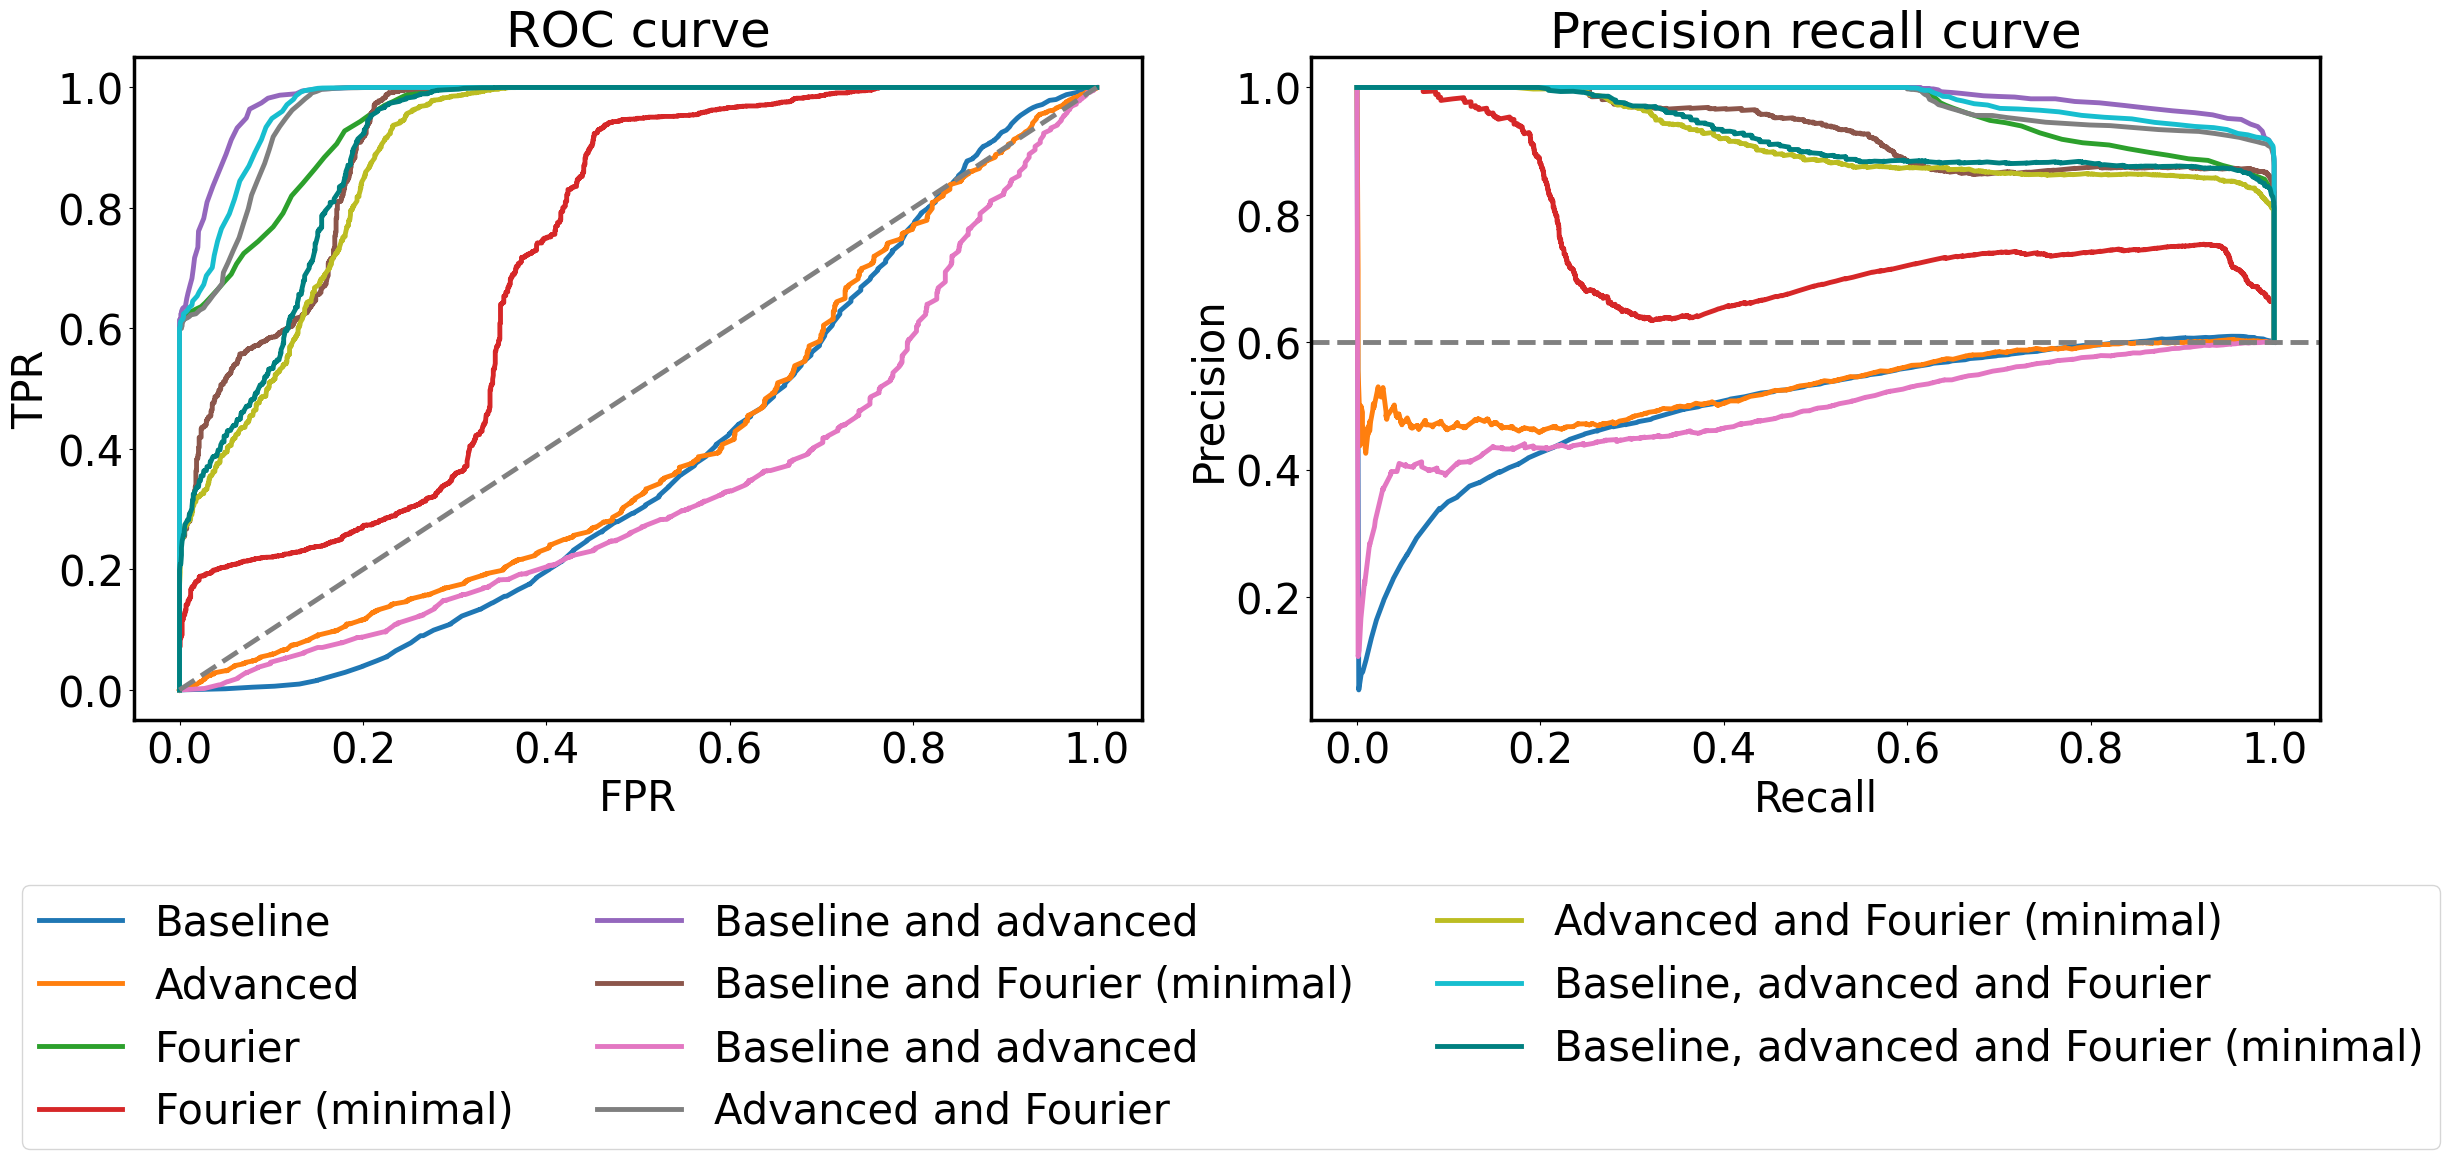

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Office Files


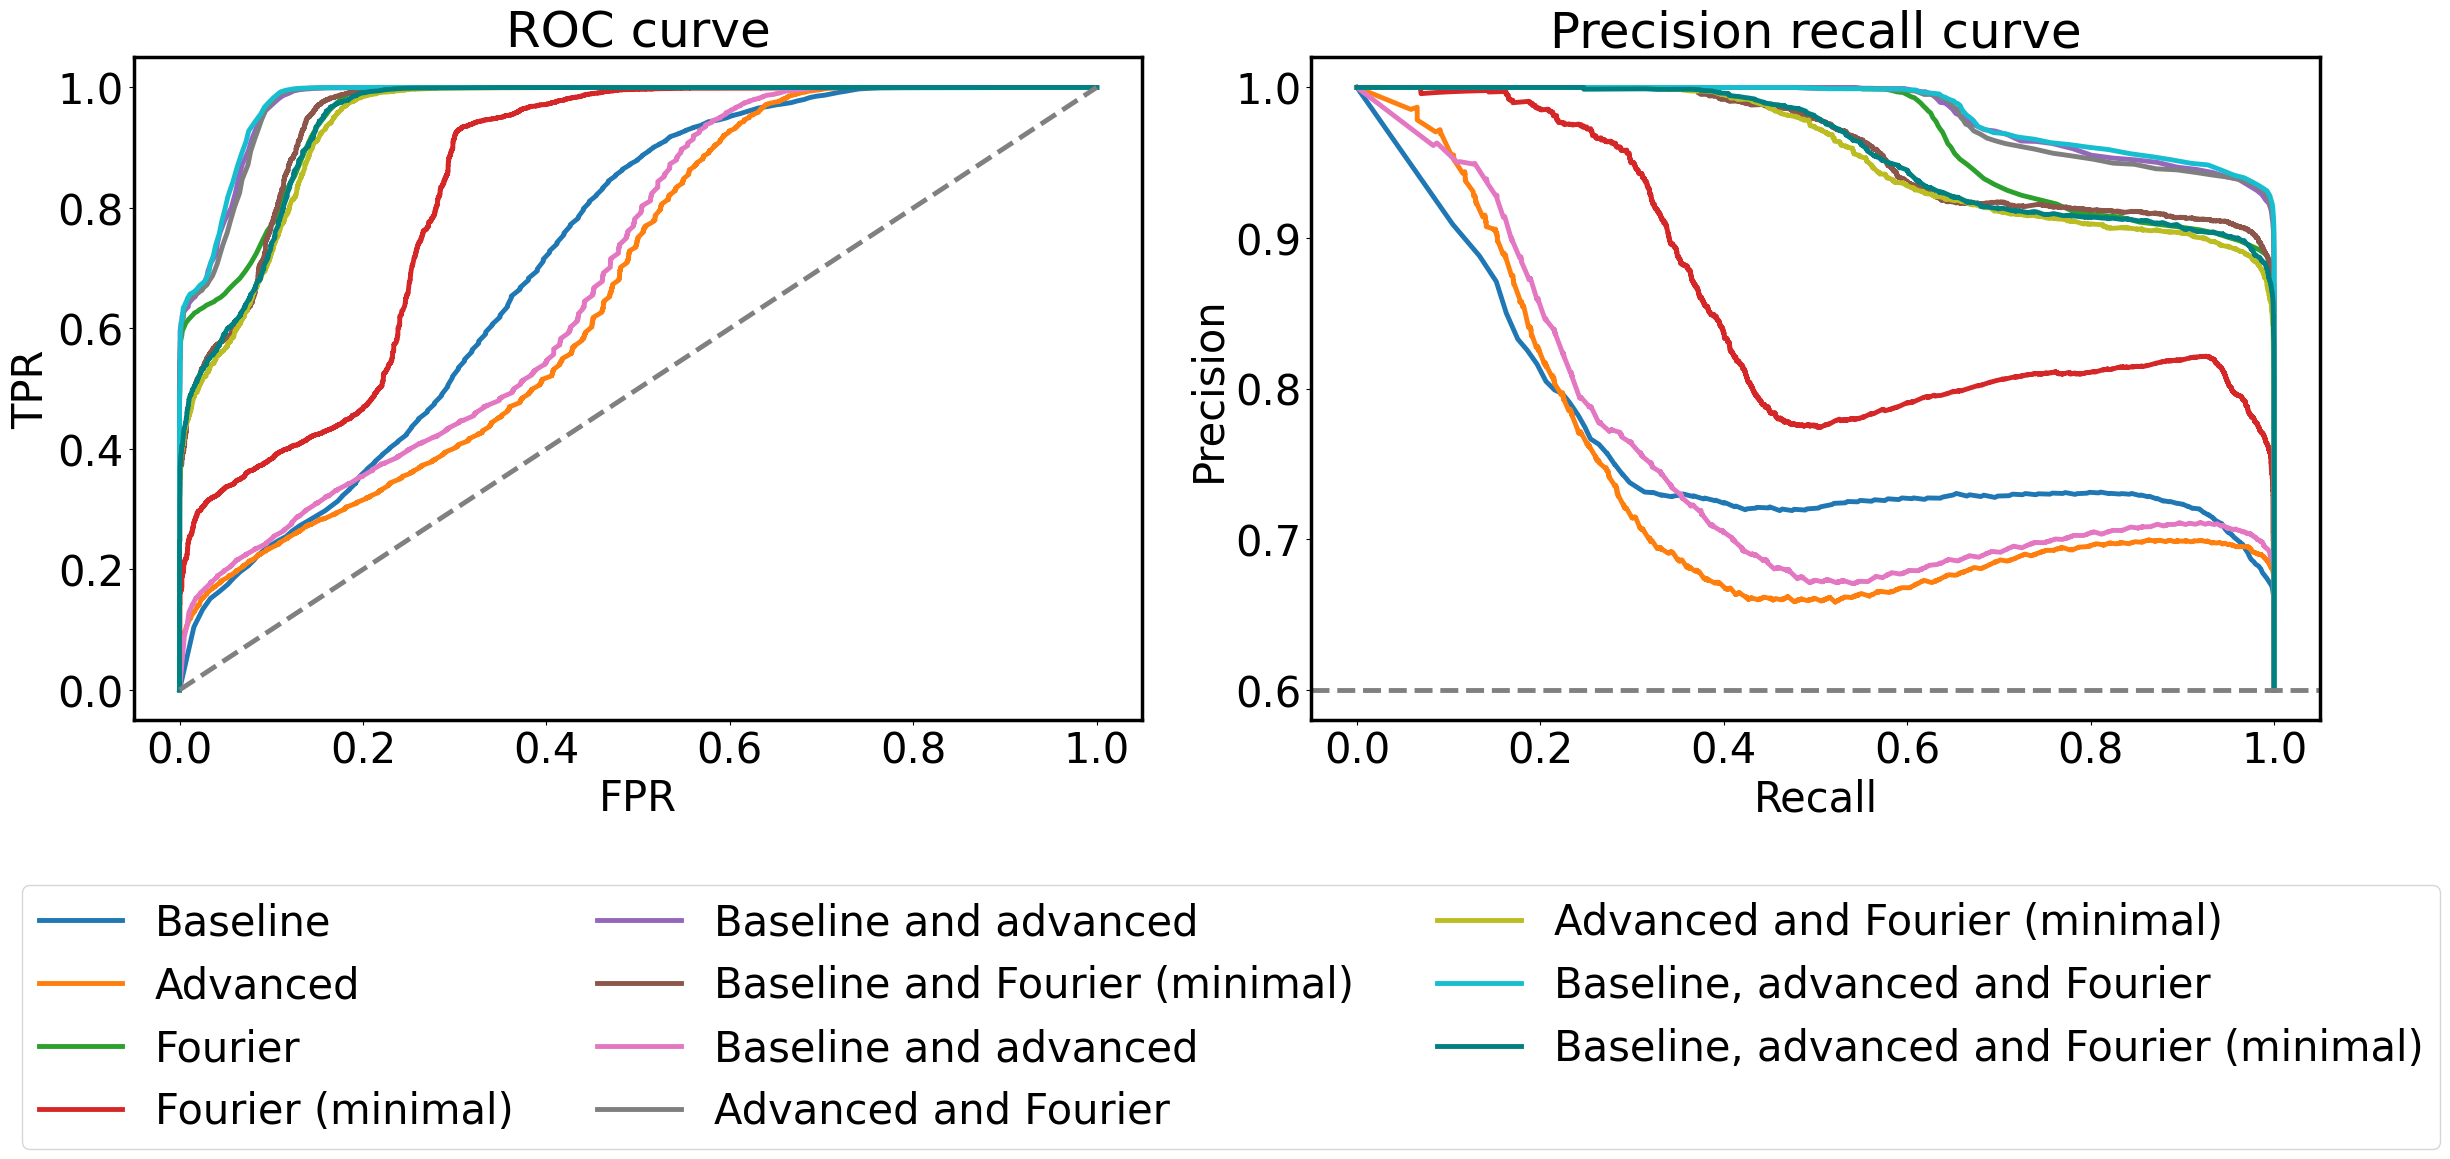

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [9]:
print("All Files")
_ = plot_model("random_forest", figsize=FIGSIZE, plot_all=True)
print("Password Protected Files")
_ = plot_model("random_forest", figsize=FIGSIZE, plot_password_protected=True)
print("Office Files")
_ = plot_model("random_forest", figsize=FIGSIZE, plot_office=True)

# Neural Network

All Files


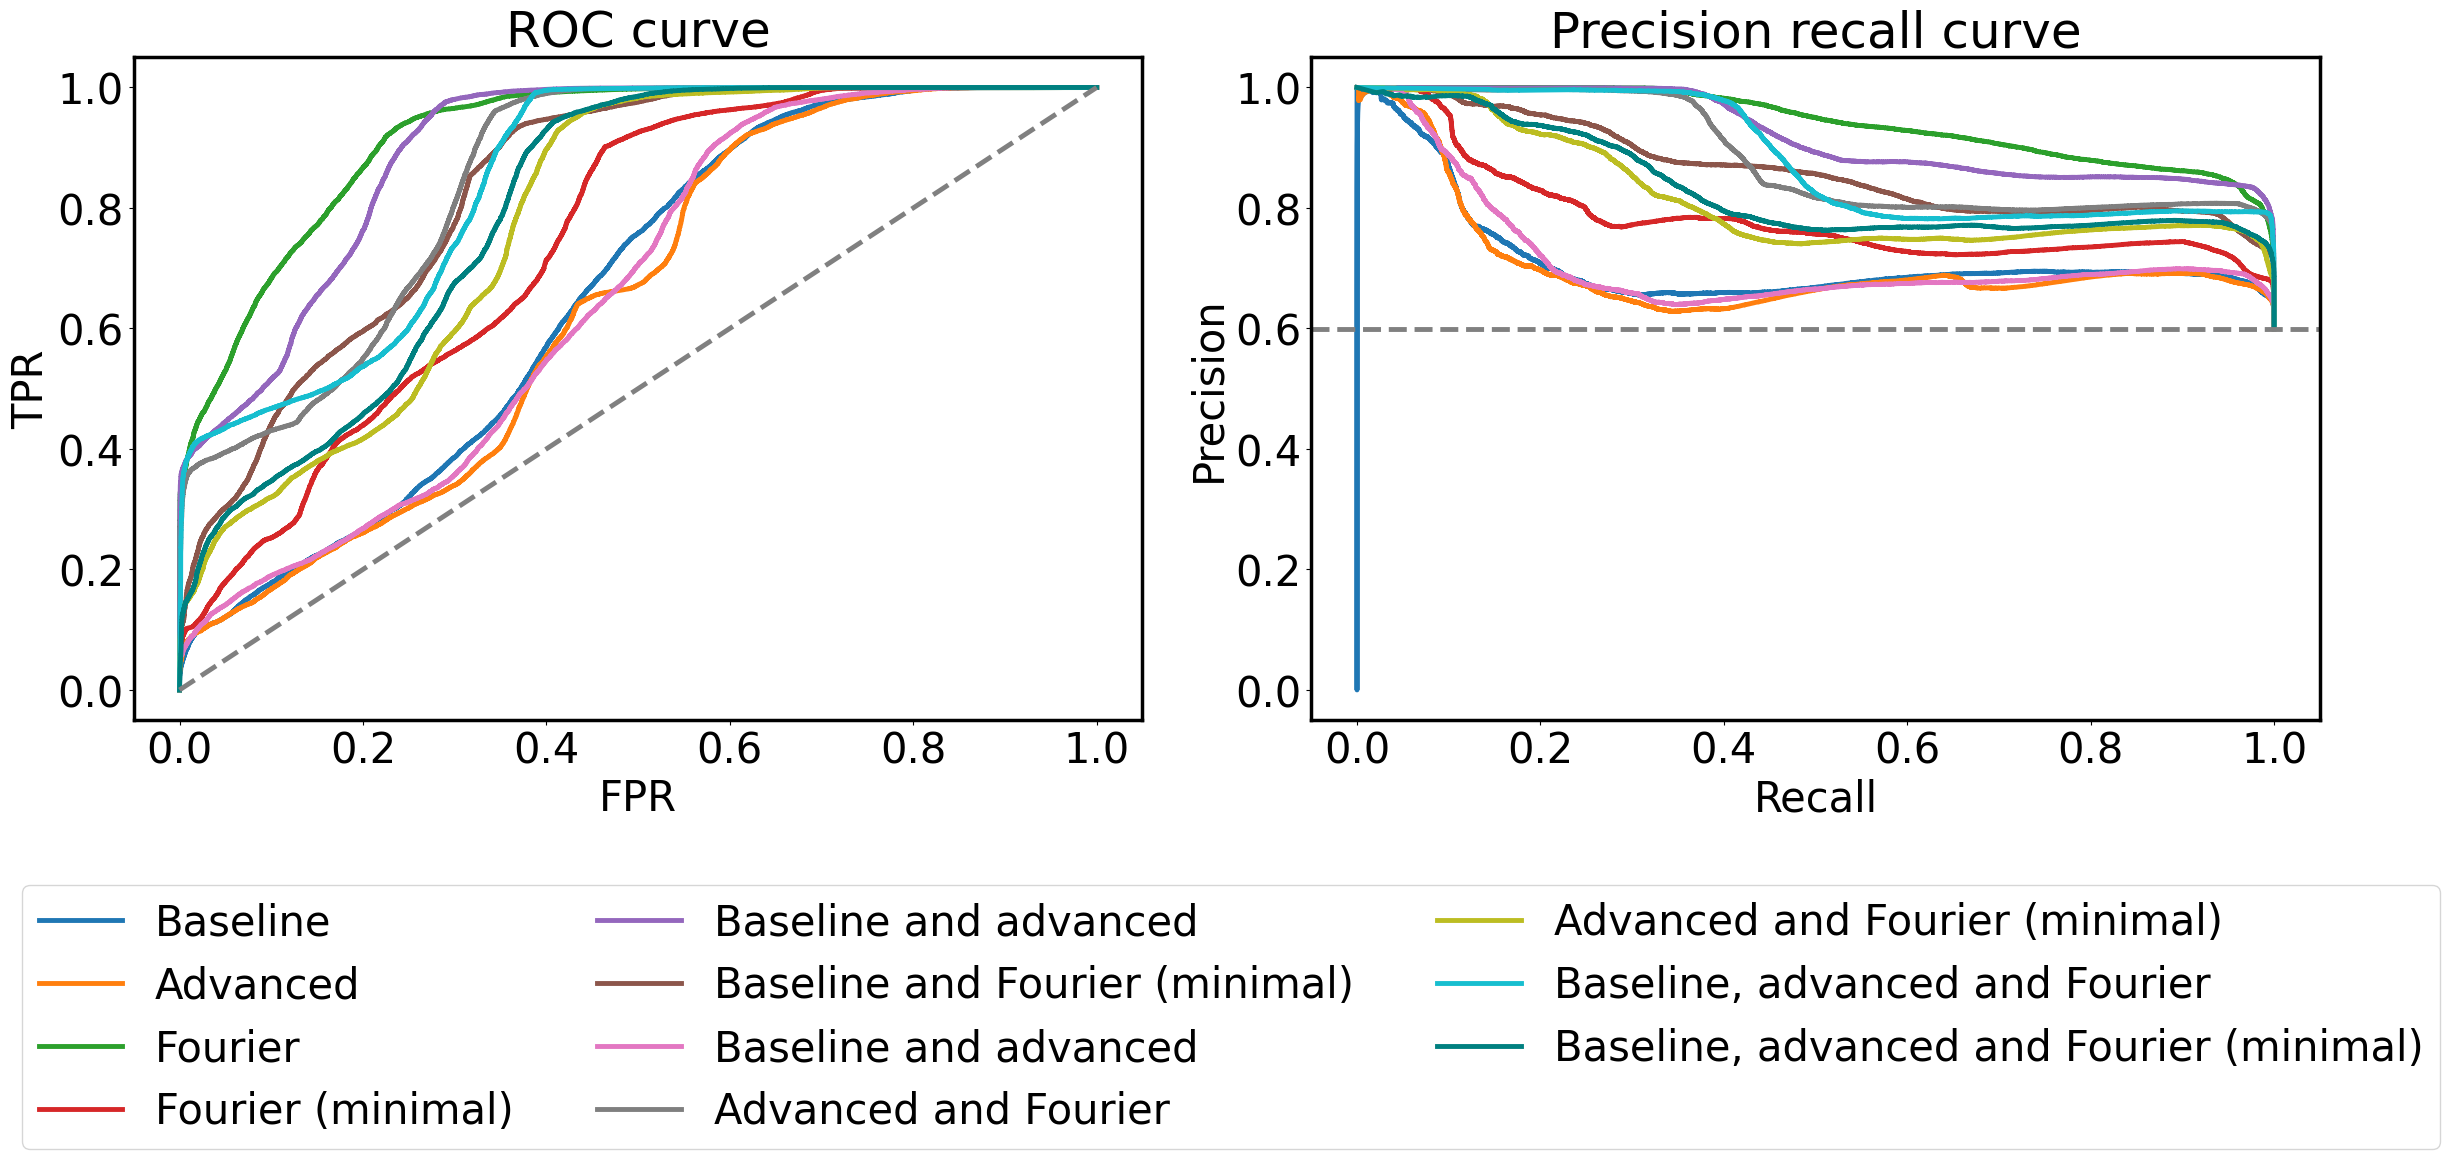

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Password Protected Files


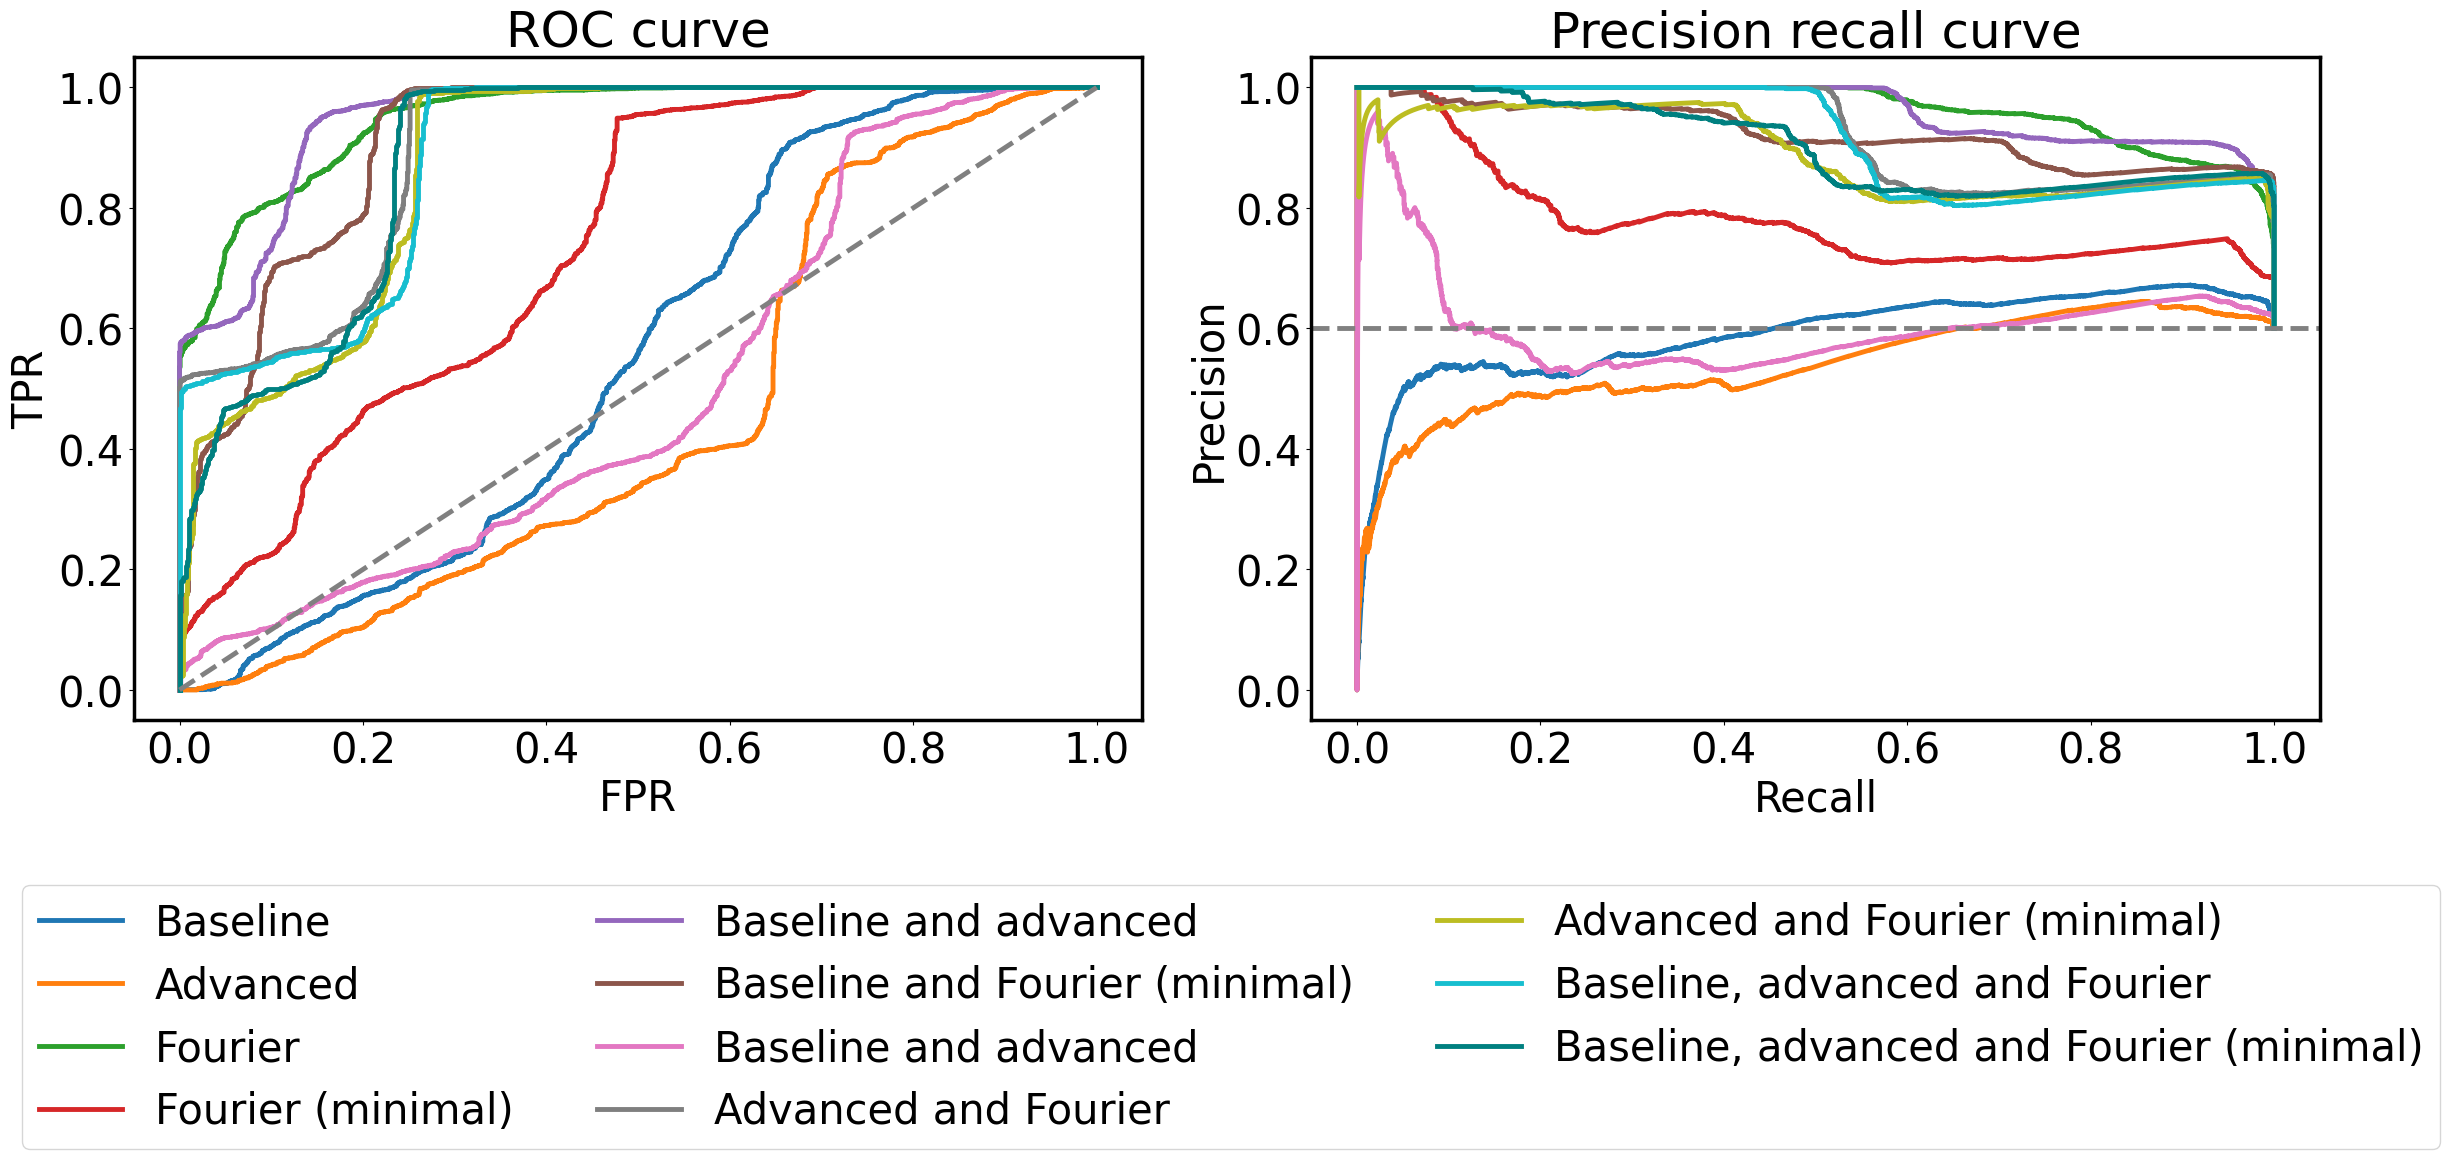

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Office Files


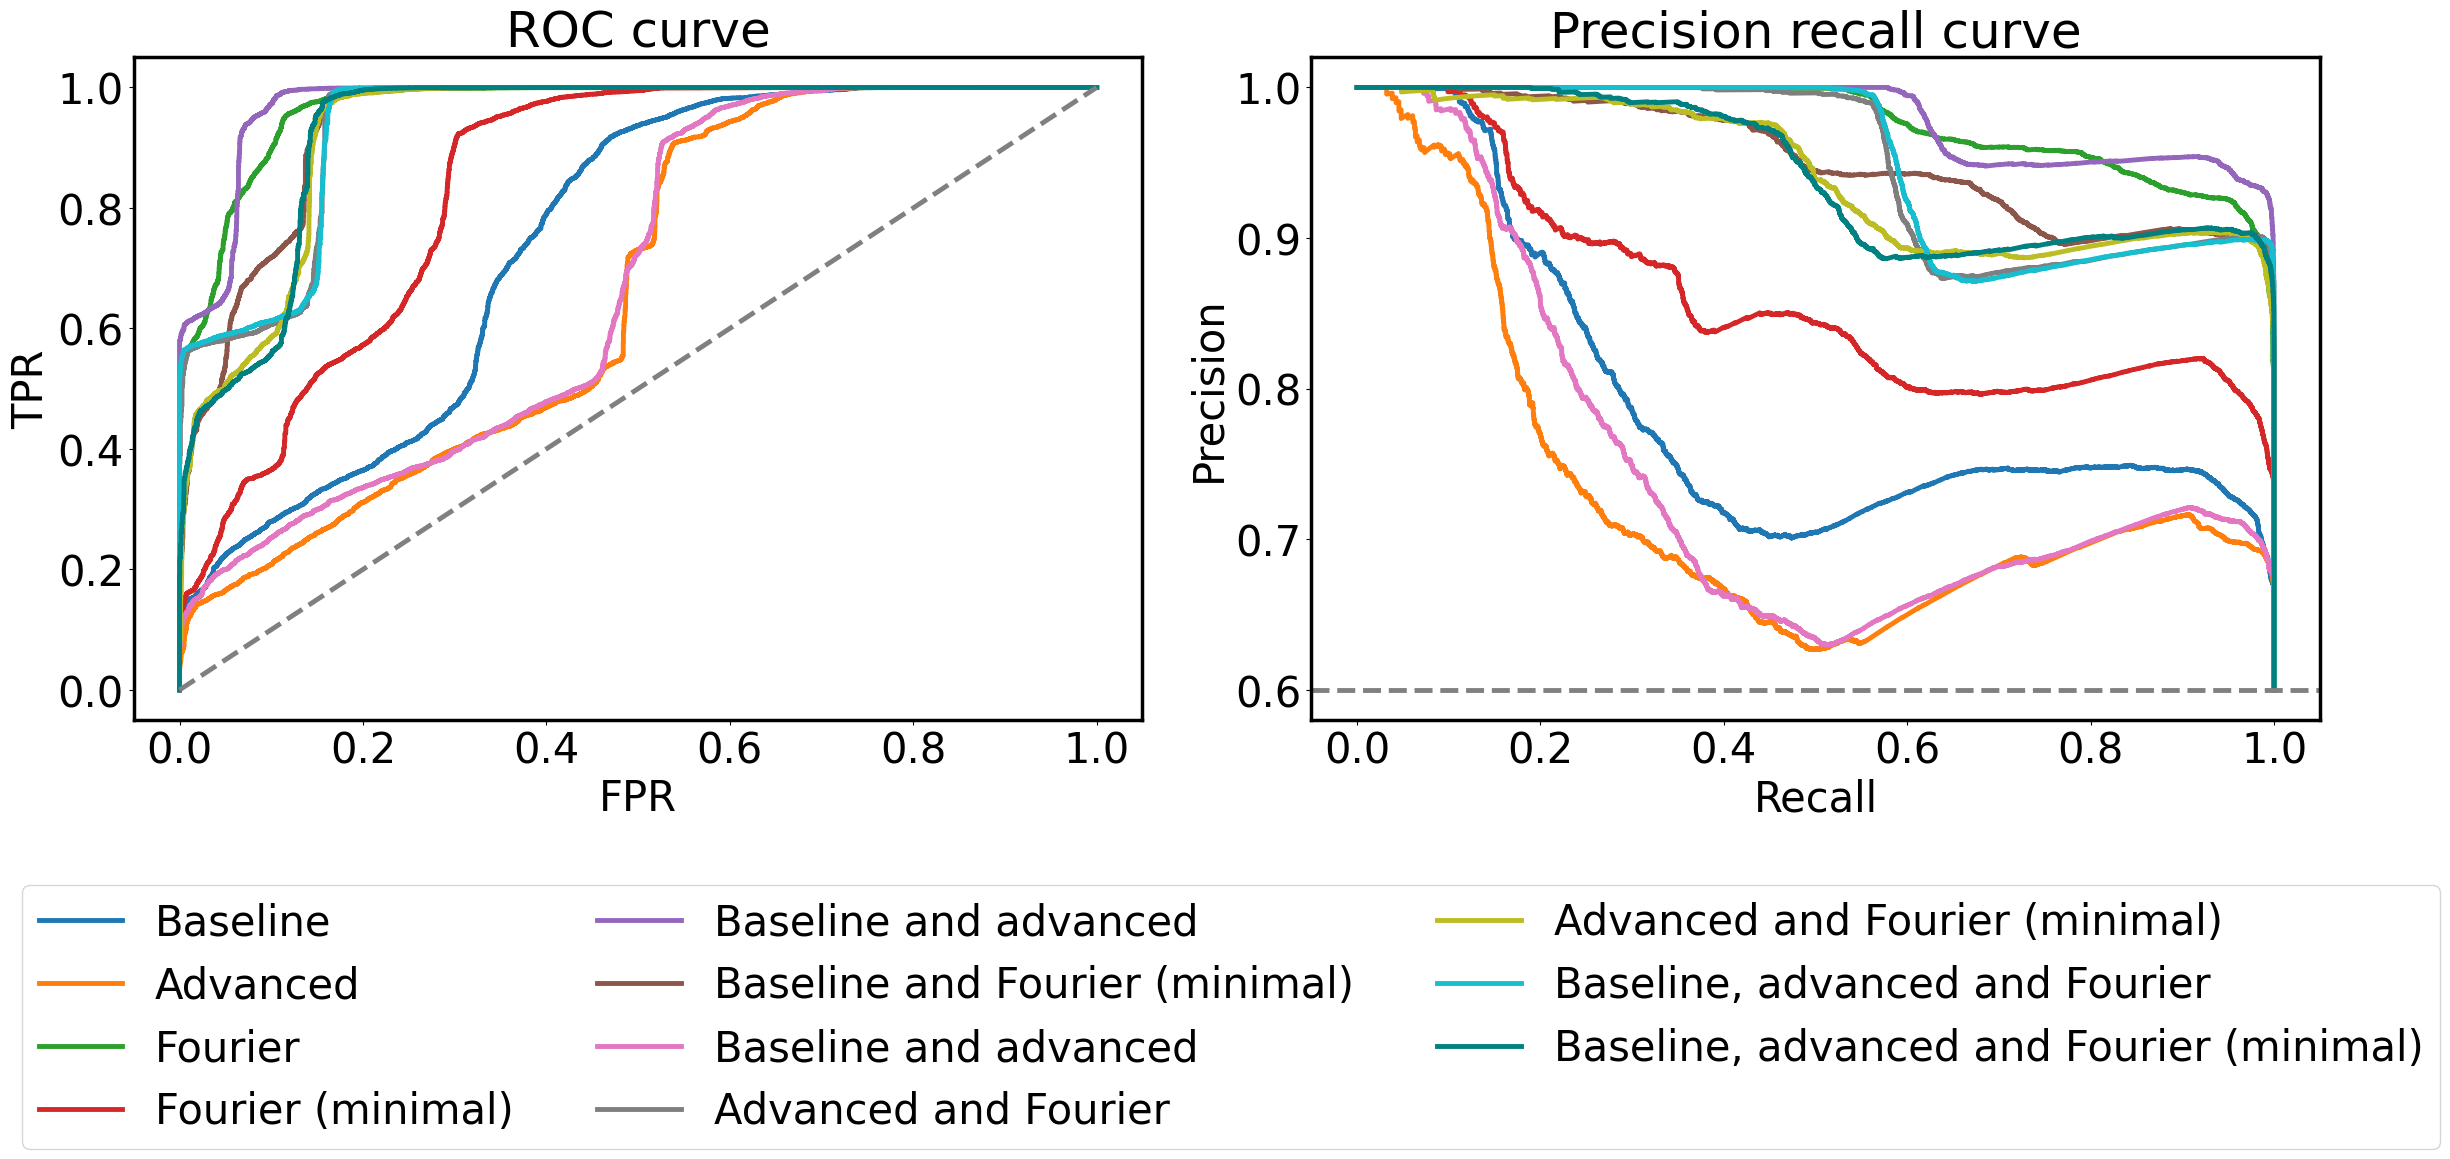

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [10]:
print("All Files")
_ = plot_model("neural_network", figsize=FIGSIZE, plot_all=True)
print("Password Protected Files")
_ = plot_model("neural_network", figsize=FIGSIZE, plot_password_protected=True)
print("Office Files")
_ = plot_model("neural_network", figsize=FIGSIZE, plot_office=True)